# Simulation-based inference with `sbijax`

Here we demonstrate a selected set of inferential algorithms.

Interactive online version of this notebook:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dirmeier/sbijax/blob/main/docs/notebooks/sbi_with_sbijax.ipynb)

In [1]:
import jax
import sbijax
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import arviz as az

def plot_posteriors(obj):
    _, axes = plt.subplots(nrows=2, ncols=2)
    with az.style.context(["arviz-doc"], after_reset=True):
        for i in range(0, 2):        
            for j in range(0, 2):
                ax = axes[i, j]
                if i < j:
                    ax.axis('off')
                else:
                    ax.hexbin(obj[..., j], obj[..., i], gridsize=50, bins='log', cmap='viridis')            
                ax.spines.left.set_linewidth(.5)
                ax.spines.bottom.set_linewidth(.5)
                ax.spines.right.set_linewidth(.5)
                ax.spines.top.set_linewidth(.5)       
                if i < 1:
                    ax.set_xticklabels([])
                    ax.xaxis.set_tick_params(width=0., length=0)
                if j != 0:                    
                    ax.set_yticklabels([])
                    ax.yaxis.set_tick_params(width=0., length=0)
                ax.grid(which='major', axis='both', alpha=0.5)
        for i in range(2):
            axes[i, i].hist(obj[..., i], color="black")
    plt.tight_layout()
    plt.show()

## Model

We use the infamous simple likelihood comples posterior model which is a common experimental benchmark for SBI methods as an example:

\begin{align}
\theta &\sim \mathcal{N}_2(0, I)\\
y \mid \theta &\sim 0.5 \ \mathcal{N}_2(\theta, I) + 0.5 \ \mathcal{N}_2(\theta, 0.01 I)
\end{align}

The observation model is parameterized by a five-dimensional random variable $\theta \sim \pi(\theta)$ for which we want to infer the posterior distribution $\pi(\theta | y_{\text{obs}}) \propto \pi(y_{\text{obs}} | \theta) \pi(\theta)$ for a specific eight-dimensional observation $y_{\text{obs}}$.

Translated into code it looks like this:

In [3]:
from jax import numpy as jnp, random as jr
from tensorflow_probability.substrates.jax import distributions as tfd


def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Normal(jnp.zeros(2), 1)
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta):
    mean = theta["theta"].reshape(-1, 2)
    n = mean.shape[0]
    data_key, cat_key = jr.split(seed)
    categories = tfd.Categorical(logits=jnp.zeros(2)).sample(seed=cat_key, sample_shape=(n,))
    scales = jnp.array([1.0, 0.1])[categories].reshape(-1, 1)
    y = tfd.Normal(mean, scales).sample(seed=data_key)
    return y

As an observation $y_{\text{obs}}$, we draw a random sample from the simulator:

In [4]:
prior_draw = prior_fn().sample(seed=jr.PRNGKey(12345))
prior_draw

{'theta': Array([ 0.7212693, -1.7704216], dtype=float32)}

In [5]:
y_obs = simulator_fn(jr.PRNGKey(12345), prior_draw)
y_obs

Array([[ 0.6982815, -1.7693155]], dtype=float32)

## MCMC posterior

In [6]:
from functools import partial
from sbijax.mcmc import sample_with_nuts

In [7]:
def log_likelihood(y, theta):
    mean = theta["theta"].reshape(1, 2)
    mix = tfd.Categorical(logits=jnp.zeros(2))
    likelihood = tfd.MixtureSameFamily(
        mixture_distribution=mix,
        components_distribution=tfd.MultivariateNormalDiag(
            jnp.concatenate([mean, mean], axis=0),
            jnp.concatenate([jnp.full((1, 2), 1.0), jnp.full((1, 2), 0.01)], axis=0),
        )
    )
    ll = likelihood.log_prob(y)
    return ll
    
def log_density_fn(theta, y):
    prior_lp = prior_fn().log_prob(theta)
    likelihood_lp = log_likelihood(y, theta)
    lp = jnp.sum(prior_lp) + jnp.sum(likelihood_lp)
    return lp

In [8]:
log_density_partial = partial(log_density_fn, y=y_obs)
mcmc_samples = sample_with_nuts(
    jr.PRNGKey(1), log_density_partial, prior_fn().sample  
)

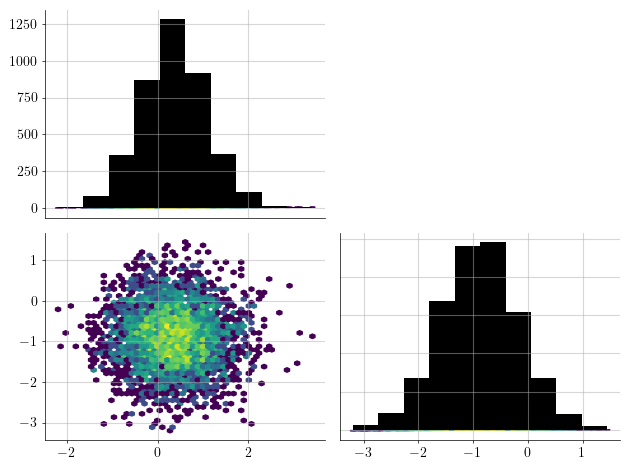

In [9]:
plot_posteriors(mcmc_samples["theta"].reshape(-1, 2))

In [10]:
from sbijax import as_inference_data, plot_rhat_and_ress

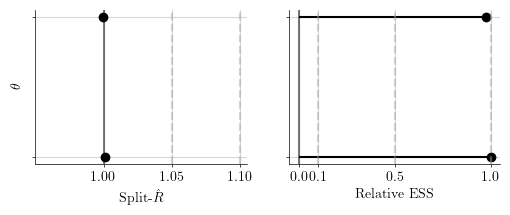

In [11]:
_, axes = plt.subplots(ncols=2, figsize=(6, 2))
plot_rhat_and_ress(as_inference_data(mcmc_samples, y_obs), axes)
plt.show()

## Likelihood estimation

We start with an algorithm that aims to approximate the likelihood function of the model. NLE methods require a density estimator that models a space with the same dimensionality as the *data* space. We use a masked autoregressive flow to model that space.

In [12]:
from sbijax.nn import make_spf

n_dim_data = y_obs.shape[-1]
neural_network = make_spf(n_dim_data, -5.0, 5.0)

In [13]:
from sbijax import NLE

fns = prior_fn, simulator_fn
nle = NLE(fns, neural_network)

We then do inference sequentially in 10 rounds.

In [14]:
data, _ = nle.simulate_data(
    jr.PRNGKey(1), n_simulations=20_000
)
nle_params, info = nle.fit(
    jr.PRNGKey(2), data=data
)

  2%|████████                                                                                                                                                                                                                                                                                                                           | 25/1000 [00:32<21:07,  1.30s/it]


In [15]:
nle_inference_results, _ = nle.sample_posterior(
    jr.PRNGKey(3), nle_params, y_obs, n_samples=10_000, n_warmup=5000, n_chains=4
)

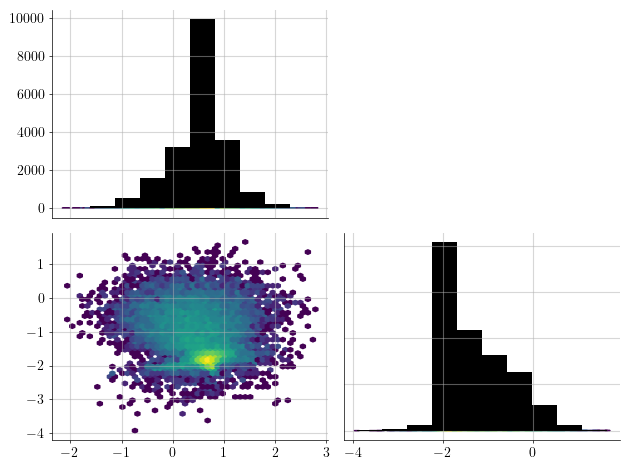

In [16]:
plot_posteriors(sbijax.inference_data_as_dictionary(nle_inference_results.posterior)["theta"])

## Posterior estimation

In [17]:
from sbijax.nn import make_cnf

n_dim_theta = 2
neural_network = make_cnf(n_dim_theta)

In [18]:
from sbijax import FMPE
fmpe = FMPE(fns, neural_network)

In [19]:
data, _ = fmpe.simulate_data(
    jr.PRNGKey(1), n_simulations=20_000
)
fmpe_params, info = fmpe.fit(
 jr.PRNGKey(2), data=data
)

  9%|█████████████████████████████                                                                                                                                                                                                                                                                                                      | 90/1000 [00:47<07:58,  1.90it/s]


In [20]:
fmpe_inference_results, diagnostics = fmpe.sample_posterior(
    jr.PRNGKey(3), fmpe_params, y_obs, n_samples=20_000
)

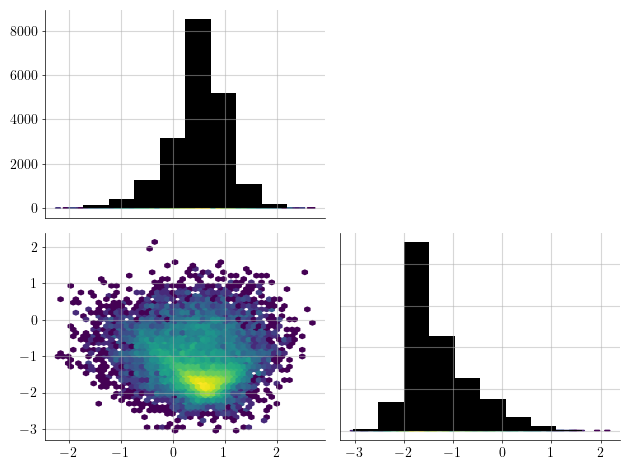

In [21]:
plot_posteriors(sbijax.inference_data_as_dictionary(fmpe_inference_results.posterior)["theta"])

## Likelihood-ratio estimation

In [22]:
from sbijax.nn import make_resnet

neural_network = make_resnet()

In [23]:
from sbijax import NRE

nre = NRE(fns, neural_network)

In [24]:
data, _ = nre.simulate_data(
    jr.PRNGKey(1), n_simulations=20_000
)
nre_params, info = nre.fit(
    jr.PRNGKey(2), data=data, n_samples=10_000, n_warmup=5000, n_chains=4
)

  4%|████████████▎                                                                                                                                                                                                                                                                                                                      | 38/1000 [01:22<34:36,  2.16s/it]


In [25]:
nre_inference_results, diagnostics = nre.sample_posterior(
    jr.PRNGKey(3), nre_params, y_obs, n_samples=10_000, n_warmup=5000, n_chains=4
)

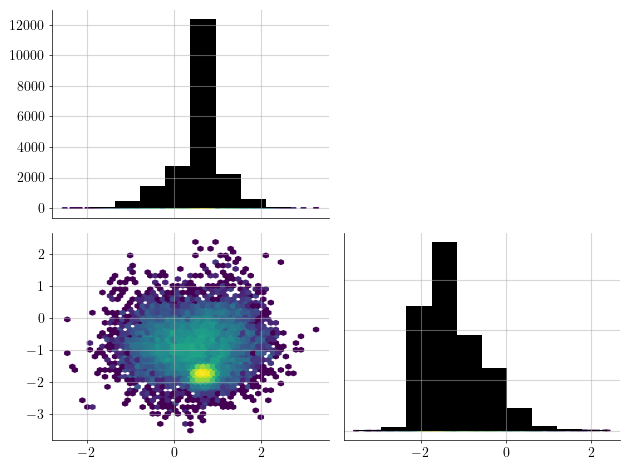

In [26]:
plot_posteriors(sbijax.inference_data_as_dictionary(nre_inference_results.posterior)["theta"])

## Session info

In [27]:
import session_info

session_info.show(html=False)

-----
arviz                       0.17.1
haiku                       0.0.11
jax                         0.4.24
jaxlib                      0.4.24
matplotlib                  3.6.2
sbijax                      1.0.0
session_info                1.0.0
tensorflow_probability      0.24.0-dev20240224
-----
IPython             8.8.0
jupyter_client      7.4.9
jupyter_core        5.1.3
jupyterlab          3.5.2
notebook            6.5.2
-----
Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) [Clang 14.0.6 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2024-07-19 18:54
